# Price base policy: price elasticity of carbon in EPPA

In [1]:
import pandas as pd
import pandas.io.excel
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
%matplotlib inline

In [2]:
#define main directory
#mainDir = 'C:/Users/Admin/Documents/xxx/Profession/EnergyProject/EMF/CarbonElasticity'
mainDir = 'C:/Users/Tee/Documents/xxx/EnergyProject/EMF/CarbonElasticity'

As we modify codes as explained earlier, we can run multiple scenarios in EPPA by creating .cas file for each price path and perturbation factor, then using a script that we wrote called 'batch_price-based.bat' in command prompt (see detail in the file) to run multiple scenarios. For EPPA, we need to run scenarios in one batch. That batch is one without any modification on carbon accounting. That is, only fossil fuel carbon is accounted for carbon tax (wait for Henry's confirmation).

We measure both price and quantities, then stack them together as a table.

In [3]:
color = 'green' #for EPPA

In [4]:
#We have a single column for population as it is exogeneous. Just read it from nopolicy scenario
#...

In [5]:
#define function to read price out (from previous note)
def pmeasure_eppa(CarbonAccounting, PricePath, perturb):
    filename = 'y_res_test_policy_price_' + PricePath + '_' + perturb + '.xls'
    directory = mainDir + '/rawresult/' + 'EPPA' + '/' + CarbonAccounting + '/'+ 'test_policy_price_' + PricePath + '_' + perturb +'/'
    cbtax = pandas.io.excel.read_excel(directory + filename, sheetname="9c_price")
    cbtax = pd.DataFrame(cbtax.stack()).reset_index()
    cbtax.columns = ['region','year','price']
    cbtax['price'] = cbtax['price']/0.84628
    cbtax['year'] = list(cbtax['year'].map(lambda x: float(x)))
    p = cbtax[(cbtax.region=='USA')][['year','price']]
    p.set_index('year',inplace=True)
    p.columns = [perturb]
    return p;

#define function to read quantities out (from previous note)
def qmeasure_eppa(CarbonAccounting, PricePath, perturb):
    filename = 'y_emit_test_policy_price_' + PricePath + '_' + perturb + '.xls'
    directory = mainDir + '/rawresult/' + 'EPPA' + '/' + CarbonAccounting + '/'+ 'test_policy_price_' + PricePath + '_' + perturb +'/'
    #total carbon emission
    CTOT = pandas.io.excel.read_excel(directory + filename, sheetname="5tot_co2")
    CTOT = pd.DataFrame(CTOT.stack()).reset_index()
    CTOT.columns = ['region','year','level']
    CTOT['level'] = CTOT['level'] #unit conversion to million ton of CO2 (MMtCO2)
    CTOT['year'] = list(CTOT['year'].map(lambda x: float(x)))
    
    #fossil + industry carbon emission
    CFI = pandas.io.excel.read_excel(directory + filename, sheetname="4fi_co2")
    CFI = pd.DataFrame(CFI.stack()).reset_index()
    CFI.columns = ['region','year','level']
    CFI['level'] = CFI['level'] #unit conversion to million ton of CO2 (MMtCO2)
    CFI['year'] = list(CFI['year'].map(lambda x: float(x)))

    #fossil carbon emission
    CFOS = pandas.io.excel.read_excel(directory + filename, sheetname="3fos_co2")
    CFOS = pd.DataFrame(CFOS.stack()).reset_index()
    CFOS.columns = ['region','year','level']
    CFOS['level'] = CFOS['level'] #unit conversion to million ton of CO2 (MMtCO2)
    CFOS['year'] = list(CFOS['year'].map(lambda x: float(x)))
     
    
    qUS_fos = CFOS[CFOS.region=='USA'][['year','level']]
    qUS_fos.set_index('year',inplace=True)
    qUS_fos.columns = [perturb]
    
    qglobal_fos = CFOS[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
    qglobal_fos.set_index('year',inplace=True)
    qglobal_fos.columns = [perturb]
    
    qUS_fi = CFI[CFI.region=='USA'][['year','level']]
    qUS_fi.set_index('year',inplace=True)
    qUS_fi.columns = [perturb]
    
    qglobal_fi = CFI[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
    qglobal_fi.set_index('year',inplace=True)
    qglobal_fi.columns = [perturb]
    
    qUS_tot = CTOT[CTOT.region=='USA'][['year','level']]
    qUS_tot.set_index('year',inplace=True)
    qUS_tot.columns = [perturb]
    
    qglobal_tot = CTOT[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
    qglobal_tot.set_index('year',inplace=True)
    qglobal_tot.columns = [perturb]
    
    return qUS_tot, qglobal_tot, qUS_fi, qglobal_fi, qUS_fos, qglobal_fos;

In [6]:
#define function to read other quantities 
def gdp_measure_eppa(CarbonAccounting, PricePath, perturb):
    filename = 'y_res_test_policy_price_' + PricePath + '_' + perturb + '.xls'
    directory = mainDir + '/rawresult/' + 'EPPA' + '/' + CarbonAccounting + '/'+ 'test_policy_price_' + PricePath + '_' + perturb +'/'
    
    #read gdp
    filename = 'gdp_' + ScenarioName + '.xlsx'
    GDP = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + ScenarioName +'/' + filename, sheetname="Sheet2", header=None, names=["year","region","level"])
    GDP['level'] = GDP['level']/0.72262 #unit conversion to trillion dollars of 2005 
    
    GDP = pandas.io.excel.read_excel(directory + filename, sheetname="1cons")
    GDP = pd.DataFrame(GDP.stack()).reset_index()
    GDP.columns = ['region','year','level']
    GDP['level'] = GDP['level']*1/0.84628/1000 #unit conversion to trillion dollars of 2005
    
    #query for USA and sum for global.
    GDP_US_EPPA = GDP[GDP.region=='USA'][['year','level']]
    GDP_US = GDP_US_EPPA
    GDP_US.set_index('year',inplace=True)
    GDP_US.columns = [perturb]
    
    
    GDP_global_EPPA = GDP[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
    GDP_global = GDP_global_EPPA
    GDP_global.set_index('year',inplace=True)
    GDP_global.columns = [perturb]
 
    return GDP_US, GDP_global;

def pe_measure_eppa(CarbonAccounting, PricePath, perturb):
    filename = 'y_res_test_policy_price_' + PricePath + '_' + perturb + '.xls'
    directory = mainDir + '/rawresult/' + 'EPPA' + '/' + CarbonAccounting + '/'+ 'test_policy_price_' + PricePath + '_' + perturb +'/'
    
    PE = pandas.io.excel.read_excel(directory + filename, sheetname="5ener")
    PE = pd.DataFrame(PE.stack()).reset_index()

    PE.columns = ['region','type','year','level']
    PE['level'] = PE['level']*1 #unit conversion to trillion dollars of 2005

    PE.loc[PE['level']=='Eps','level'] = 0 #Fix the unknown to zero
    
    #query for USA and sum for global.
    #Note we need to sum over types of generation as well
    PE_US_EPPA = PE[PE.region=='USA'][['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
    PE_US = PE_US_EPPA
    PE_US.set_index('year',inplace=True)
    PE_US.columns = [perturb]
    
    
    PE_global_EPPA = PE[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
    PE_global = PE_global_EPPA
    PE_global.set_index('year',inplace=True)
    PE_global.columns = [perturb]
 
    return PE_US, PE_global;

In [7]:
def constructpq_table(PricePath):
    ptable = pd.DataFrame()
    qUS_tot_table = pd.DataFrame()
    qglobal_tot_table = pd.DataFrame()
    qUS_fi_table = pd.DataFrame()
    qglobal_fi_table = pd.DataFrame()
    qUS_fos_table = pd.DataFrame()
    qglobal_fos_table = pd.DataFrame()
    for perturb in ['p085','p090','p095','p100','p105','p110','p115']:
        p = pmeasure_eppa(CarbonAccounting, PricePath, perturb)
        ptable = pd.concat([ptable,p],axis=1)
        qUS_tot, qglobal_tot, qUS_fi, qglobal_fi, qUS_fos, qglobal_fos = qmeasure_eppa(CarbonAccounting, PricePath, perturb)
        qUS_tot_table = pd.concat([qUS_tot_table,qUS_tot],axis=1)
        qglobal_tot_table = pd.concat([qglobal_tot_table,qglobal_tot],axis=1)
        qUS_fi_table = pd.concat([qUS_fi_table,qUS_fi],axis=1)
        qglobal_fi_table = pd.concat([qglobal_fi_table,qglobal_fi],axis=1)
        qUS_fos_table = pd.concat([qUS_fos_table,qUS_fos],axis=1)
        qglobal_fos_table = pd.concat([qglobal_fos_table,qglobal_fos],axis=1)
    return ptable, qUS_tot_table, qglobal_tot_table,qUS_fi_table, qglobal_fi_table, qUS_fos_table, qglobal_fos_table;

In [8]:
#Construct additional table for GDP and PE
def constructGDPPE_table(PricePath):
    GDP_US_table = pd.DataFrame()
    GDP_global_table = pd.DataFrame()
    PE_US_table = pd.DataFrame()
    PE_global_table = pd.DataFrame()
    for perturb in ['p085','p090','p095','p100','p105','p110','p115']:
        
        GDP_US, GDP_global = gdp_measure_eppa(CarbonAccounting, PricePath, perturb)
        GDP_US_table = pd.concat([GDP_US_table,GDP_US],axis=1)
        GDP_global_table = pd.concat([GDP_global_table,GDP_global],axis=1)
        PE_US, PE_global = pe_measure_eppa(CarbonAccounting, PricePath, perturb)
        PE_US_table = pd.concat([PE_US_table,PE_US],axis=1)
        PE_global_table = pd.concat([PE_global_table,PE_global],axis=1)
    return GDP_US_table, GDP_global_table,PE_US_table, PE_global_table;

## Default option: accounting fossil fuel carbon emission (FOS)

This is accounting fossil fuel carbon emission.

In [9]:
CarbonAccounting = 'price-based-fos' # 'price' vs. 'quantity' and tot' vs. 'fos'

p_step050, qUS_tot_step050, qglobal_tot_step050, qUS_fi_step050, qglobal_fi_step050, qUS_fos_step050, qglobal_fos_step050 = constructpq_table('step050')
p_step100, qUS_tot_step100, qglobal_tot_step100, qUS_fi_step100, qglobal_fi_step100, qUS_fos_step100, qglobal_fos_step100 = constructpq_table('step100')
p_step200, qUS_tot_step200, qglobal_tot_step200, qUS_fi_step200, qglobal_fi_step200, qUS_fos_step200, qglobal_fos_step200 = constructpq_table('step200')
#p_step400, qUS_tot_step400, qglobal_tot_step400, qUS_fi_step400, qglobal_fi_step400, qUS_fos_step400, qglobal_fos_step400 = constructpq_table('step400')


In [14]:

GDP_US_step050, GDP_global_step050, PE_US_step050, PE_global_step050 = constructGDPPE_table('step050')
GDP_US_step100, GDP_global_step100, PE_US_step100, PE_global_step100 = constructGDPPE_table('step100')
GDP_US_step200, GDP_global_step200, PE_US_step200, PE_global_step200 = constructGDPPE_table('step200')


NameError: global name 'ScenarioName' is not defined

Here we plot all types of carbon emission with different perturbations under different step prices.

In [ ]:
#PE_global_step050

(0, 100000)

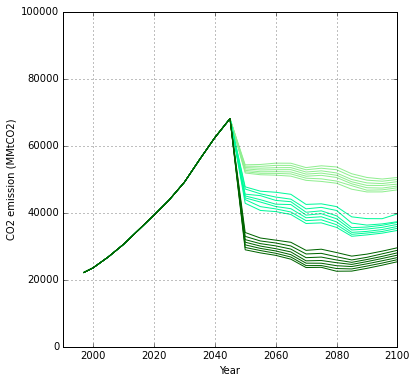

In [12]:
fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
df1 = qglobal_fos_step050
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='lightgreen',linestyle='-')
df1 = qglobal_fos_step100
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='mediumspringgreen',linestyle='-')
df1 = qglobal_fos_step200
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='darkgreen',linestyle='-')
ax1.set_ylabel('CO2 emission (MMtCO2)')
ax1.set_xlabel('Year')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

NameError: name 'GDP_global_step050' is not defined

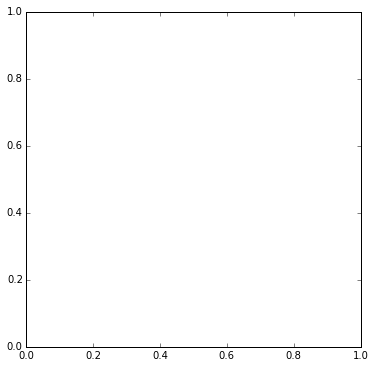

In [13]:
fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
#df1 = qglobal_fos_step050
df1 = GDP_global_step050
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='lightgreen',linestyle=':')
#df1 = qglobal_fos_step100
df1 = GDP_global_step100
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='mediumspringgreen',linestyle=':')
#df1 = qglobal_fos_step200
df1 = GDP_global_step200
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='darkgreen',linestyle=':')
ax1.set_ylabel('GDP (trillion dollars)')
ax1.set_xlabel('Year')
#ax1.set_xlim(1990,2100)
#ax1.set_ylim(0,100000)

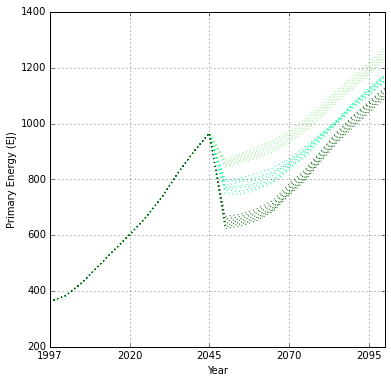

In [36]:
fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
#df1 = qglobal_fos_step050
df1 = PE_global_step050
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='lightgreen',linestyle=':')
#df1 = qglobal_fos_step100
df1 = PE_global_step100
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='mediumspringgreen',linestyle=':')
#df1 = qglobal_fos_step200
df1 = PE_global_step200
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='darkgreen',linestyle=':')
ax1.set_ylabel('Primary Energy (EJ)')
ax1.set_xlabel('Year')
#ax1.set_xlim(1990,2100)
#ax1.set_ylim(0,100000)

Note that the variation of GDP is so small compared to PE and C as the price of carbon changes.

Since EPPA accounts only fossil fuel carbon emission, it makes sense to use fossil fuel carbon emission as $q$. Here we do regression between $\log{p}$ and $\log{q}$ to measure elasticity. Note that EPPA does not have foresight, so the carbon emission change sharply in 2050. Here we start measuring price elasticity of carbon emission in 2050.

In [45]:
def accumulated_elasticity(p,q):
    x = np.log10(np.array(p[p.index>=2050]))[0]
    #y = np.log10(np.array(q[q.index==yearlist[i]]))[0]
    y = np.log10(np.array(q[q.index>=2050].sum(axis=0)))
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    l = [results.params[1]]+list(results.conf_int()[1])
    return [l[0],(l[2]-l[1])*0.5];

In [ ]:
def constructelasticity_table(p,q):
    elasticity_table = pd.DataFrame(columns = ('year','value','lower','upper'))
    yearlist = [2050, 2060, 2070, 2080, 2090, 2100]
    for i in range(0,len(yearlist)):
        x = np.log10(np.array(p[p.index==yearlist[i]]))[0]
        y = np.log10(np.array(q[q.index==yearlist[i]]))[0]
        X = sm.add_constant(x)
        model = sm.OLS(y, X)
        results = model.fit()
        elasticity_table.loc[i] = [yearlist[i], results.params[1]]+list(results.conf_int()[1])
    return elasticity_table;

(-4, 0)

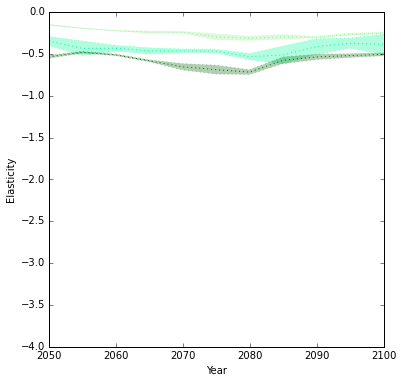

In [46]:
#fig = plt.figure(figsize=(3,8))

#ax1  = fig.add_subplot(211)
#fig = plt.figure(figsize=(3,8))
fig = plt.figure(figsize=(6,6))

ax1  = fig.add_subplot(111)
#ax1  = fig.add_subplot(211)

elasticity_table = constructelasticity_table(p_step050,qglobal_fos_step050)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='lightgreen',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='lightgreen',linestyle=':', alpha=0.3)   
elasticity_table = constructelasticity_table(p_step100,qglobal_fos_step100)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='mediumspringgreen',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='mediumspringgreen',linestyle=':', alpha=0.3)  
elasticity_table = constructelasticity_table(p_step200,qglobal_fos_step200)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='darkgreen',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='darkgreen',linestyle=':', alpha=0.3)          

ax1.set_ylabel('Elasticity')
ax1.set_xlabel('Year')
#ax1.set_title(CarbonAccounting +': global')
ax1.set_ylim(-4,0)

In [48]:
accumulated_elasticity(p_step050,qglobal_fos_step050)

[-0.25169323388636755, 0.01103714594343326]

In [49]:
accumulated_elasticity(p_step100,qglobal_fos_step100)

[-0.43816368534141859, 0.030028696605709893]

In [50]:
accumulated_elasticity(p_step200,qglobal_fos_step200)

[-0.57050710473484045, 0.0082470904100545583]

## Alternative option: accounting all carbon emission (TOT)

This is total carbon emission.

In [37]:
CarbonAccounting = 'price-based-tot' # 'price' vs. 'quantity' and tot' vs. 'fos'

p_step050, qUS_tot_step050, qglobal_tot_step050, qUS_fi_step050, qglobal_fi_step050, qUS_fos_step050, qglobal_fos_step050 = constructpq_table('step050')
p_step100, qUS_tot_step100, qglobal_tot_step100, qUS_fi_step100, qglobal_fi_step100, qUS_fos_step100, qglobal_fos_step100 = constructpq_table('step100')
p_step200, qUS_tot_step200, qglobal_tot_step200, qUS_fi_step200, qglobal_fi_step200, qUS_fos_step200, qglobal_fos_step200 = constructpq_table('step200')
#p_step400, qUS_tot_step400, qglobal_tot_step400, qUS_fi_step400, qglobal_fi_step400, qUS_fos_step400, qglobal_fos_step400 = constructpq_table('step400')


In [38]:
GDP_US_step050, GDP_global_step050, PE_US_step050, PE_global_step050 = constructGDPPE_table('step050')
GDP_US_step100, GDP_global_step100, PE_US_step100, PE_global_step100 = constructGDPPE_table('step100')
GDP_US_step200, GDP_global_step200, PE_US_step200, PE_global_step200 = constructGDPPE_table('step200')

Here we plot all types of carbon emission with different perturbations under different step prices.

(0, 100000)

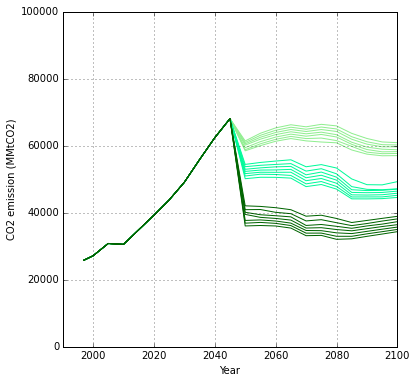

In [39]:
fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
df1 = qglobal_tot_step050
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='lightgreen',linestyle='-')
df1 = qglobal_tot_step100
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='mediumspringgreen',linestyle='-')
df1 = qglobal_tot_step200
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='darkgreen',linestyle='-')
ax1.set_ylabel('CO2 emission (MMtCO2)')
ax1.set_xlabel('Year')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

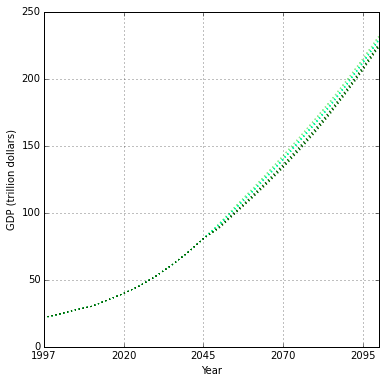

In [41]:
fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
#df1 = qglobal_fos_step050
df1 = GDP_global_step050
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='lightgreen',linestyle=':')
#df1 = qglobal_fos_step100
df1 = GDP_global_step100
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='mediumspringgreen',linestyle=':')
#df1 = qglobal_fos_step200
df1 = GDP_global_step200
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='darkgreen',linestyle=':')
ax1.set_ylabel('GDP (trillion dollars)')
ax1.set_xlabel('Year')
#ax1.set_xlim(1990,2100)
#ax1.set_ylim(0,100000)

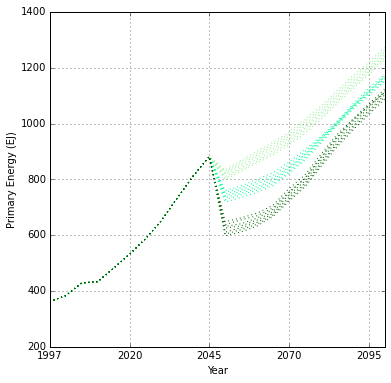

In [42]:
fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
#df1 = qglobal_fos_step050
df1 = PE_global_step050
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='lightgreen',linestyle=':')
#df1 = qglobal_fos_step100
df1 = PE_global_step100
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='mediumspringgreen',linestyle=':')
#df1 = qglobal_fos_step200
df1 = PE_global_step200
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='darkgreen',linestyle=':')
ax1.set_ylabel('Primary Energy (EJ)')
ax1.set_xlabel('Year')
#ax1.set_xlim(1990,2100)
#ax1.set_ylim(0,100000)

In the second batch (account total carbon in tax calculation), it makes sense to use total fuel carbon emission as $q$. Here we do regression between $\log{p}$ and $\log{q}$ to measure elasticity. Note that EPPA has no perfect foresight, so the carbon emission changes in 2050. Here we start measuring price elasticity of carbon emission in 2050.

Note that 400 dollars tax reaches the corner solution where there is not much change of carbon emission in US. Hence, we will omit that case in carbon elasticity measurement.

(-4, 0)

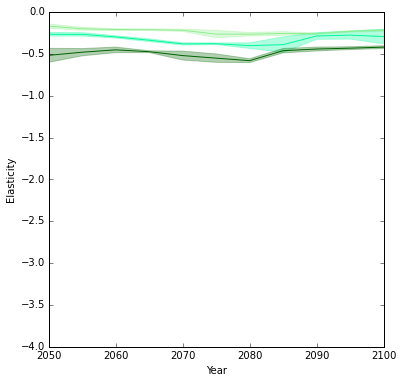

In [53]:
#fig = plt.figure(figsize=(3,8))
fig = plt.figure(figsize=(6,6))

ax1  = fig.add_subplot(111)
#ax1  = fig.add_subplot(211)

elasticity_table = constructelasticity_table(p_step050,qglobal_tot_step050)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='lightgreen')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='lightgreen', alpha=0.3)   
elasticity_table = constructelasticity_table(p_step100,qglobal_tot_step100)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='mediumspringgreen')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='mediumspringgreen', alpha=0.3)  
elasticity_table = constructelasticity_table(p_step200,qglobal_tot_step200)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='darkgreen')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='darkgreen', alpha=0.3)          
ax1.set_ylabel('Elasticity')
ax1.set_xlabel('Year')
#ax1.set_title(CarbonAccounting +': global')
ax1.set_ylim(-4,0)


In [55]:
accumulated_elasticity(p_step050,qglobal_tot_step050)

[-0.22776746238139722, 0.013713387939886967]

In [56]:
accumulated_elasticity(p_step100,qglobal_tot_step100)

[-0.32514177085158735, 0.02558115907053593]

In [57]:
accumulated_elasticity(p_step200,qglobal_fos_step200)

[-0.62096163113578484, 0.011551170650218379]